<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [33]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [34]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Т.к. batch_size - это количество элементов, передаваемых в модель за одну итерацию, то чем их больше, тем будет быстрее проходить обучение. 

Посмотрим на какую-нибудь картинку:

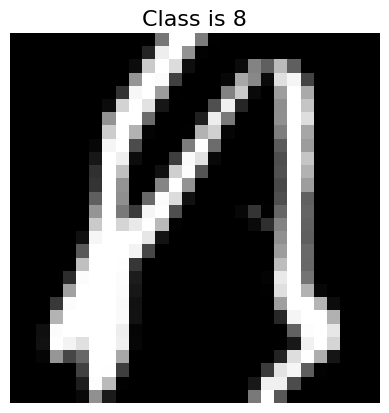

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [ ]:
list_of_classes = []
list_of_pictures = []
for i in range(batch_size):
  if trainset[i][1] not in list_of_classes:
    list_of_classes += [trainset[i][1]]
    list_of_pictures += [trainset[i][0]]
print(list_of_classes)

[8, 7, 0, 1, 4, 2, 5, 6, 9, 3]


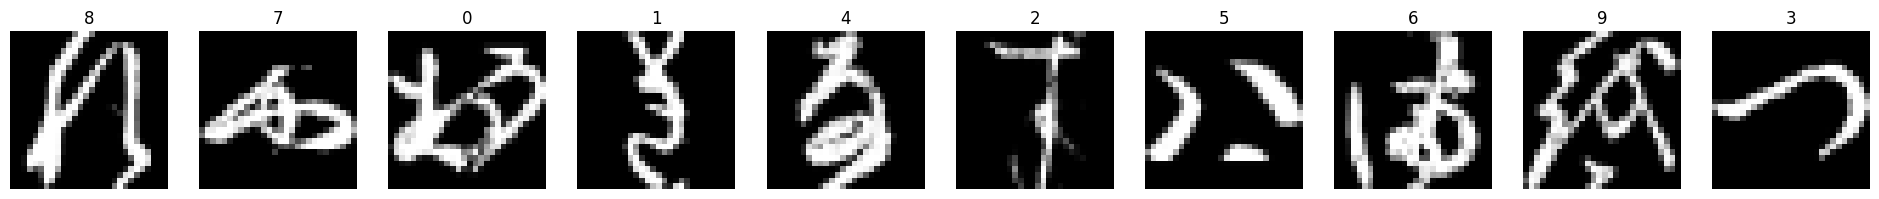

In [ ]:
plt.rcParams["figure.figsize"] = 24, 13
for i in range(10):
    plt.subplot(1, 10, i+1)
    pixels = list_of_pictures[i].reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(list_of_classes[i])
    plt.axis("off")

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # Опрелелим три слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        # self.activation = nn.ReLU() # можно так, а можно уже в forward'е
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)
        # У нас пока что логиты
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**   
1 слой: весов 784 * 256, смещений 256,  
2 слой: весов 256 * 128, смещений 128,  
3 слой: весов 128 * 10, смещений 10  

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [13]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [35]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [36]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.9238
Epoch=2 loss=0.4479
Epoch=3 loss=0.3507
Epoch=4 loss=0.2965
Epoch=5 loss=0.2543
Epoch=6 loss=0.2209
Epoch=7 loss=0.1917
Epoch=8 loss=0.1682
Epoch=9 loss=0.1493
Epoch=10 loss=0.1319
CPU times: user 29.5 s, sys: 1.97 s, total: 31.5 s
Wall time: 1min 49s


In [37]:
get_accuracy(fc_net, testloader)

0.8775

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [5]:
from statistics import mean

In [6]:
whole_mean = []
for i in range(len(trainset)):
  whole_mean += [trainset[i][0].mean().item()]
mean = mean(whole_mean)

In [7]:
whole_std = []
for i in range(len(trainset)):
  whole_std += [trainset[i][0].std().item()]
std = sum(whole_std)/len(whole_std)

In [8]:
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19176215064801896 0.3385266238119453


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")



Epoch=1 loss=0.6816
Epoch=2 loss=0.3038
Epoch=3 loss=0.2256
Epoch=4 loss=0.1780
Epoch=5 loss=0.1415
Epoch=6 loss=0.1148
Epoch=7 loss=0.0944
Epoch=8 loss=0.0772
Epoch=9 loss=0.0632
Epoch=10 loss=0.0512
CPU times: user 30.2 s, sys: 2.92 s, total: 33.1 s
Wall time: 2min 45s


In [ ]:
get_accuracy(fc_net, testloader)

0.8939

Как изменилась `accuracy` после нормализации?

Подросла

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
class FCNet_Sigm(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # Опрелелим три слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        # self.activation = nn.ReLU() # можно так, а можно уже в forward'е
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        logits = self.fc3(x)
        # У нас пока что логиты
        return logits


In [ ]:
fc_net = FCNet_Sigm()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.5232
Epoch=2 loss=0.7375
Epoch=3 loss=0.5369
Epoch=4 loss=0.4372
Epoch=5 loss=0.3675
Epoch=6 loss=0.3143
Epoch=7 loss=0.2723
Epoch=8 loss=0.2370
Epoch=9 loss=0.2075
Epoch=10 loss=0.1826
CPU times: user 30.9 s, sys: 2.89 s, total: 33.8 s
Wall time: 2min 48s


In [ ]:
get_accuracy(fc_net, testloader)    # sigmoid

0.8579

In [9]:
class FCNet_Gelu(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # Опрелелим три слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        # self.activation = nn.ReLU() # можно так, а можно уже в forward'е
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)
        # У нас пока что логиты
        return logits


In [10]:
fc_net = FCNet_Gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [11]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6585
Epoch=2 loss=0.2860
Epoch=3 loss=0.2090
Epoch=4 loss=0.1606
Epoch=5 loss=0.1269
Epoch=6 loss=0.1012
Epoch=7 loss=0.0802
Epoch=8 loss=0.0651
Epoch=9 loss=0.0519
Epoch=10 loss=0.0407
CPU times: user 30.5 s, sys: 1.91 s, total: 32.4 s
Wall time: 2min 29s


In [14]:
get_accuracy(fc_net, testloader)   # gelu

0.9001

In [ ]:
class FCNet_Tanh(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # Опрелелим три слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        # self.activation = nn.ReLU() # можно так, а можно уже в forward'е
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        logits = self.fc3(x)
        # У нас пока что логиты
        return logits


In [ ]:
fc_net = FCNet_Tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7683
Epoch=2 loss=0.3778
Epoch=3 loss=0.2532
Epoch=4 loss=0.1811
Epoch=5 loss=0.1337
Epoch=6 loss=0.1000
Epoch=7 loss=0.0749
Epoch=8 loss=0.0561
Epoch=9 loss=0.0409
Epoch=10 loss=0.0296
CPU times: user 31.6 s, sys: 2.79 s, total: 34.4 s
Wall time: 2min 46s


In [ ]:
get_accuracy(fc_net, testloader)    # tanh

0.8903

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

gelu

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
class FCNet_Gelu(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # Опрелелим три слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        # self.activation = nn.ReLU() # можно так, а можно уже в forward'е
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)
        # У нас пока что логиты
        return logits

In [15]:
fc_net = FCNet_Gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)

In [16]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4357
Epoch=2 loss=0.2342
Epoch=3 loss=0.1735
Epoch=4 loss=0.1336
Epoch=5 loss=0.1058
Epoch=6 loss=0.0837
Epoch=7 loss=0.0657
Epoch=8 loss=0.0522
Epoch=9 loss=0.0403
Epoch=10 loss=0.0310
CPU times: user 28.6 s, sys: 1.85 s, total: 30.4 s
Wall time: 2min 38s


In [17]:
get_accuracy(fc_net, testloader)   # gelu   # RMSprop

0.9018

In [18]:
fc_net = FCNet_Gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

In [19]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.3205
Epoch=2 loss=0.7977
Epoch=3 loss=0.6770
Epoch=4 loss=0.6172
Epoch=5 loss=0.5783
Epoch=6 loss=0.5503
Epoch=7 loss=0.5286
Epoch=8 loss=0.5104
Epoch=9 loss=0.4959
Epoch=10 loss=0.4830
CPU times: user 28.2 s, sys: 1.97 s, total: 30.1 s
Wall time: 2min 27s


In [20]:
get_accuracy(fc_net, testloader)   # gelu   # Adagrad

0.7282

RMSprop показал себя лучше, чем Adam и Adagrad

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [24]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = max(0, x)
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [25]:
class FCNet_CustomReLU(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # Опрелелим три слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        # self.activation = nn.ReLU() # можно так, а можно уже в forward'е
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.CustomReLU(x)
        x = self.fc2(x)
        x = F.CustomReLU(x)
        logits = self.fc3(x)
        # У нас пока что логиты
        return logits

In [26]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [27]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6828
Epoch=2 loss=0.2965
Epoch=3 loss=0.2188
Epoch=4 loss=0.1698
Epoch=5 loss=0.1367
Epoch=6 loss=0.1102
Epoch=7 loss=0.0903
Epoch=8 loss=0.0740
Epoch=9 loss=0.0607
Epoch=10 loss=0.0488
CPU times: user 29.6 s, sys: 2.05 s, total: 31.6 s
Wall time: 2min 35s


In [28]:
get_accuracy(fc_net, testloader)

0.8971

Вроде ок

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

ruDALLE после midjourney мне как-то вообще не зашел, поэтому вот несколько моих экспериментов с midjourney

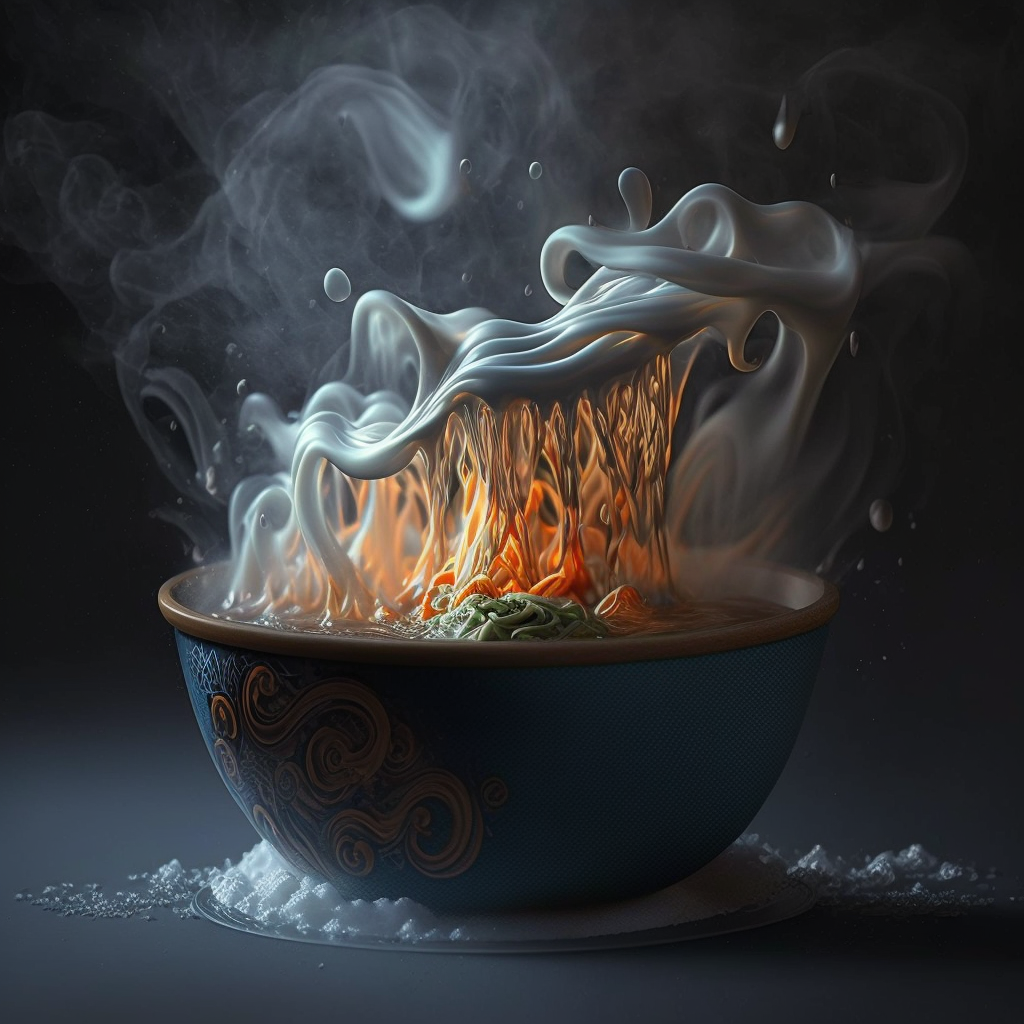

In [5]:
from IPython.display import Image
Image('../data/termofisher25_Buy_instant_noodles_pour_boiling_water_on_them_an_d81d09d8-e5c4-4b77-a460-a792a6bc5f4e.png', width=320, height=320)
# купи доширак, залей кипятком, и не жалей ни о ком

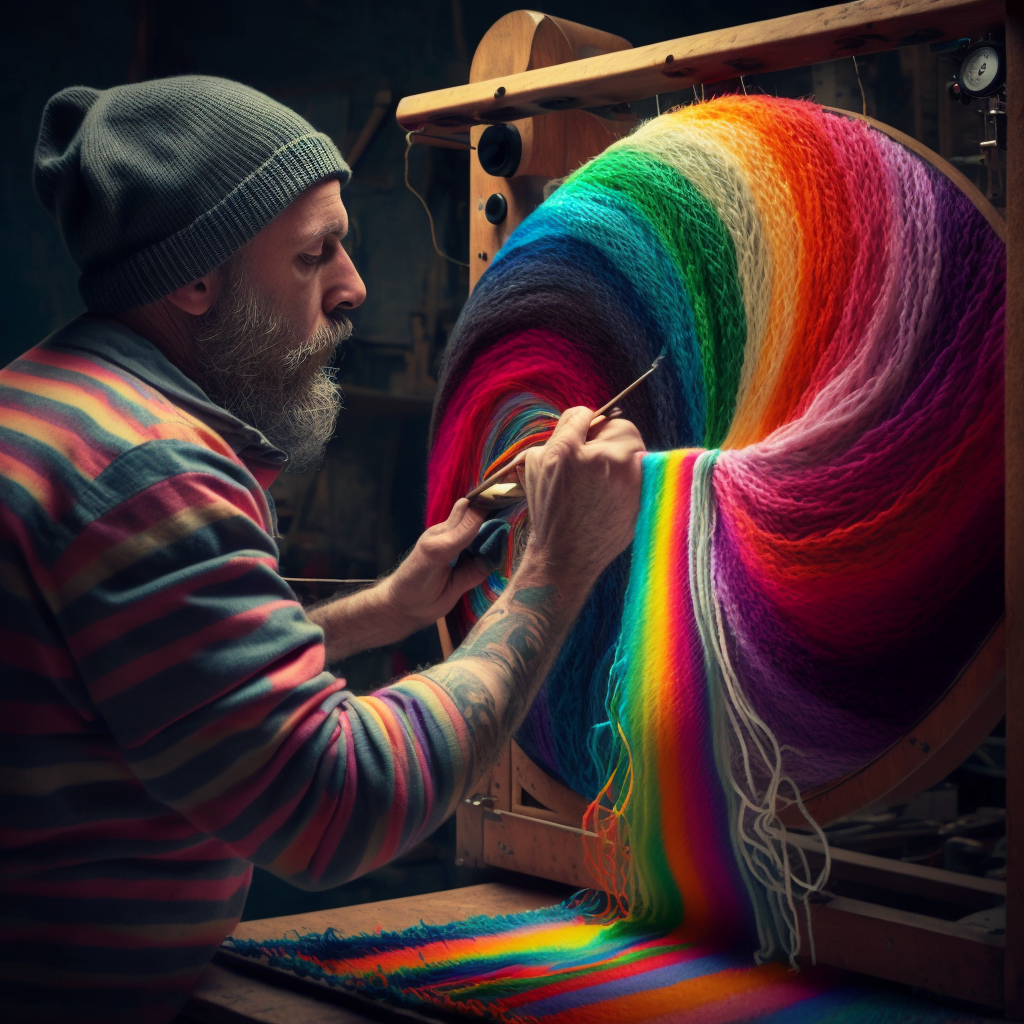

In [3]:
Image('../data/notarobot22_weaving_the_rainbow_283a1ef4-b055-4156-bab2-fd709808c81d.png', width=320, height=320)
# расплетая радугу

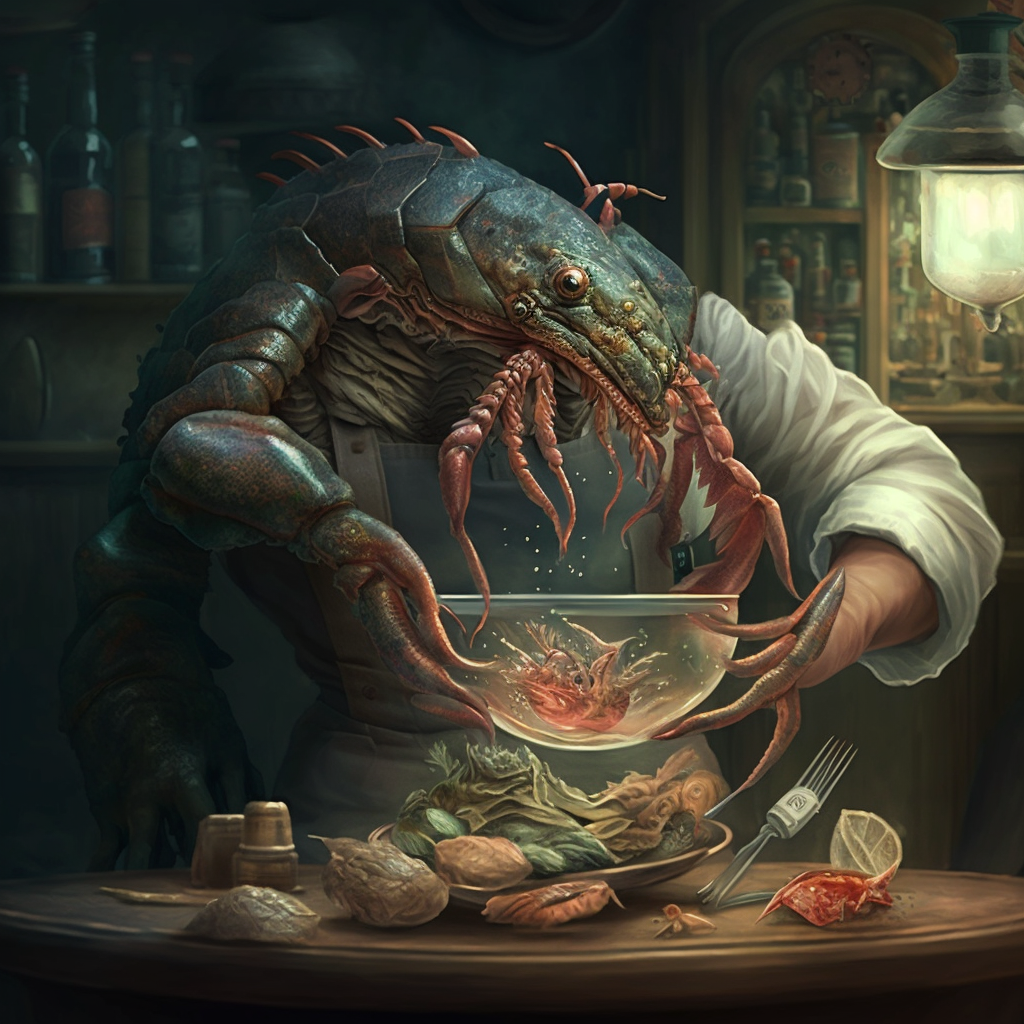

In [4]:
Image('../data/varenikissalsoy2_the_barman_flicks_a_flint_and_the_crustacean_r_dc52d944-d8ce-410a-be50-0e36beae3125.png', width=320, height=320)
# бармен чиркает кремнем, и ракообразное поднимается со своей тарелки с овощами, клацая клешнями